In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pqm import pqm_chi2, pqm_pvalue
from scipy.stats import norm, chi2, uniform, kstest
import torch
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create a distribution, and sample from it twice

In [2]:
class TimeSeriesModel:
    def __init__(self, a = 0., sigma=1., nt=100):
        self.t = np.linspace(0, 10, nt)
        self.a = a
        self.sigma = sigma
        
    def generate_samples(self, num_samples):
        # Generate samples from each component
        y = self.a * np.cos(self.t) + self.sigma * np.random.randn(num_samples, len(self.t))
        return torch.tensor(y, device=device)


In [3]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
chisqs_mean = np.zeros_like(amps)
chisqs_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    zs = []
    z = pqm_chi2(y_samples, null_samples, re_tessellation=num_repeats)
    zs += z
        
    chisqs_mean[i] = np.median(zs)
    chisqs_std[i] = np.std(zs)
    print(a, chisqs_mean[i], chisqs_std[i])

0.01 96.11161747189968 11.64773911575413
0.012742749857031334 92.67063519734171 11.743338038628774
0.016237767391887217 105.54414130961266 13.431526484887547
0.0206913808111479 97.02114236620763 11.57314322796672
0.026366508987303583 105.674604431095 11.390233272683334
0.03359818286283781 102.40430141512206 11.122194530198685
0.04281332398719394 109.76697180977054 16.076578639195915
0.0545559478116852 124.15572310831934 17.456802620203
0.06951927961775606 128.44815900016584 11.487582372816508
0.08858667904100823 138.78378673297453 17.945762743294612
0.11288378916846889 182.13400207553872 25.601134873336267
0.14384498882876628 260.22579084861013 31.557234168082182
0.18329807108324356 348.8627926568396 53.75676240609243
0.23357214690901212 601.622508217612 72.79019500864337
0.29763514416313175 1057.60541469576 178.40422692940837
0.37926901907322497 1929.810013474761 250.1601736213478
0.4832930238571752 3441.111769789316 265.6864691439481
0.615848211066026 5891.84173448075 521.32533459080

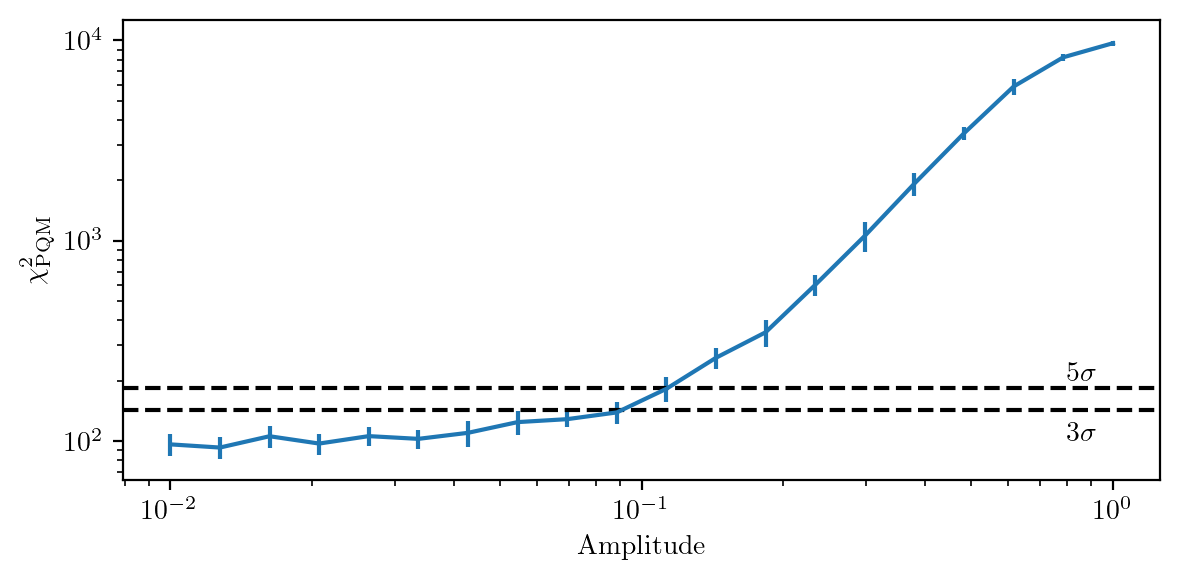

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(amps, chisqs_mean, yerr=chisqs_std)
ax.axhline(chi2.ppf(0.997300203936740, 99), ls='--', color='k')
ax.axhline(chi2.ppf(0.999999426696856, 99), ls='--', color='k')
ax.text(0.8, 100, r'$3 \sigma$')
ax.text(0.8, 200, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('$\chi^2_{\mathrm{ PQM}}$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

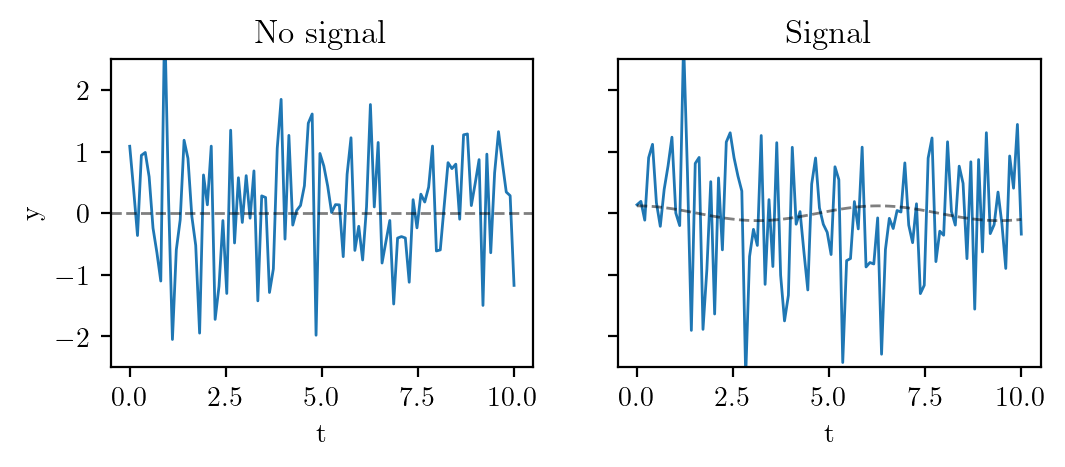

In [5]:
gmm = TimeSeriesModel(a = 0.12)
gmm_null = TimeSeriesModel(a = 0)
x_samples = gmm.generate_samples(num_samples=2)
null_samples = gmm_null.generate_samples(num_samples=2)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(6, 2), sharex=True, sharey=True)
axs[0].plot(gmm.t, null_samples[0], lw=1)
axs[0].axhline(0, color='k', lw=1, ls='--', alpha=0.5)
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_xlabel('t')
axs[0].set_ylabel('y')
axs[0].set_title('No signal')

axs[1].plot(gmm.t, x_samples[0], lw=1)
axs[1].plot(gmm.t, gmm.a * np.cos(gmm.t), color='k', lw=1, ls='--', alpha=0.5)
axs[1].set_ylim([-2.5, 2.5])
axs[1].set_title('Signal')
axs[1].set_xlabel('t')

plt.show()

# Using p-value

In [6]:
num_repeats = 20
gmm_null = TimeSeriesModel(a = 0)

amps = np.logspace(-2, 0, 20)
p_val_mean = np.zeros_like(amps)
p_val_std = np.zeros_like(amps)

for i, a in enumerate(amps):
    gmm = TimeSeriesModel(a = a)
    null_samples = gmm_null.generate_samples(num_samples=5000)
    y_samples = gmm.generate_samples(num_samples=5000)
    p_val = []
    pval = pqm_pvalue(y_samples, null_samples, re_tessellation=num_repeats)
    p_val += pval
    p_val_mean[i] = np.median(p_val)
    p_val_std[i] = np.std(p_val)

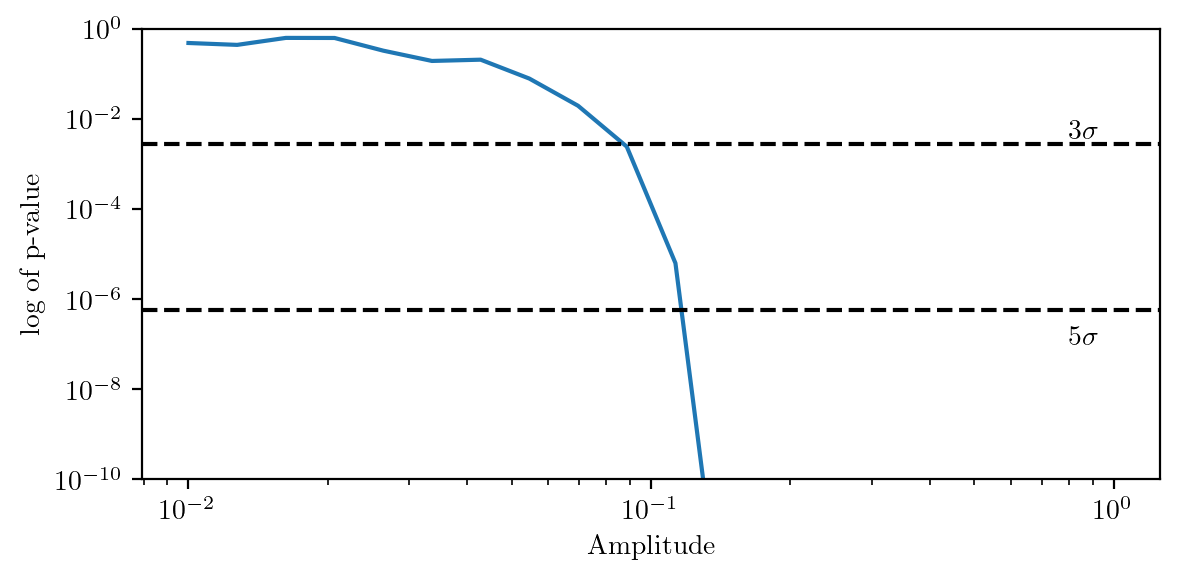

In [7]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(amps, p_val_mean)
ax.axhline(1 - 0.997300203936740, ls='--', color='k')  # 3 sigma equivalent p-value
ax.axhline(1 - 0.999999426696856, ls='--', color='k')  # 5 sigma equivalent p-value
ax.text(0.8, 0.01, r'$3 \sigma$', verticalalignment='top')
ax.text(0.8, 0.0000001, r'$5 \sigma$')
ax.set_xlabel('Amplitude')
ax.set_ylabel('log of p-value')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-10, 1)  # Set the y-axis limits
plt.tight_layout()
plt.show()
